# Final Project: Load balancing

Author : Jed MOUTAHIR

In [209]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [222]:
class LoadBalencingEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, lambdA, mu1, mu2, gamma, Q1_max, Q2_max):
        self.lambdA = lambdA
        self.mu1 = mu1
        self.mu2 = mu2
        self.gamma = gamma
        self.Q1 = 0
        self.Q2 = 0
        self.state = (self.Q1, self.Q2)

        self.actions = np.arange(2)     # define set of actions
        self.Q1_max = Q1_max
        self.Q2_max = Q2_max

    def reward(self):
        return self.state[0] + self.state[1]
    
    def step(self, action):
        # Take action (0 or 1) and return reward.

        event = np.random.uniform()

        # Is there a departure?
        if(event < self.mu1 and self.Q1 > 0):
            self.Q1 -= 1
        if(self.mu1 < event < self.mu1 + self.mu2 and self.Q2 > 0):
            self.Q2 -= 1

        # Is there an arrival?
        if(self.mu1 + self.mu2 < event < self.mu1 + self.mu2 + self.lambdA):
            # Is there space?        
            if(self.Q1 < self.Q1_max and self.Q2 < self.Q2_max):
                # Choose queue
                if(action == 0):
                    self.Q1 += 1
                else:
                    self.Q2 += 1

        self.state = (self.Q1, self.Q2)
        reward = self.reward()

        return reward, self.state

In [223]:
class Agent(object):
    # Class which defines the agent. Each agent has a decision rule and a learning rule.
    
    def __init__(self, lambdA, mu1, mu2, gamma, env):
        self.lambdA = lambdA
        self.mu1 = mu1
        self.mu2 = mu2
        self.gamma = gamma
        self.env = env
        self.name = "Agent"

    def learn(self, action, reward, new_state):
        # given action and reward, update value function.
        pass
            
    def act(self):
        # action.
        if(self.env.Q1 >= self.env.Q1_max):
            return self.env.actions[1]
        elif(self.env.Q2 >= self.env.Q2_max):
            return self.env.actions[0]
        else:
            selected_action = np.random.choice(self.env.actions)

        return selected_action

In [224]:
def simulateLoadBalencing(lambdA, mu1, mu2, gamma, Q1_max, Q2_max, N):
    # function that simulates the agent's behaviour
    
    environment = LoadBalencingEnv(lambdA, mu1, mu2, gamma, Q1_max, Q2_max)
    agent = Agent(lambdA, mu1, mu2, gamma, environment)
    rewards = np.zeros(N)
    actions = np.zeros(N)
    load_1 = np.zeros(N)
    load_2 = np.zeros(N)
    for n in np.arange(N):
        action = agent.act()
        reward, next_state = environment.step(action)
        agent.learn(action, reward, next_state)
        rewards[n] = reward
        actions[n] = action
        load_1[n] = environment.Q1
        load_2[n] = environment.Q2

    return rewards, actions, load_1, load_2

In [225]:
def plotResults(rewards, actions, load_1, load_2, N):
    # function that plots the results of the simulation
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0, 0].plot(np.arange(N), rewards)
    ax[0, 0].set_xlabel("Time")
    ax[0, 0].set_ylabel("Reward")
    ax[0, 0].set_title("Reward over time")
    ax[0, 1].plot(np.arange(N), actions)
    ax[0, 1].set_xlabel("Time")
    ax[0, 1].set_ylabel("Action")
    ax[0, 1].set_title("Action over time")
    ax[1, 0].plot(np.arange(N), load_1)
    ax[1, 0].set_xlabel("Time")
    ax[1, 0].set_ylabel("Load")
    ax[1, 0].set_title("Load queue 1 over time")
    ax[1, 1].plot(np.arange(N), load_2)
    ax[1, 1].set_xlabel("Time")
    ax[1, 1].set_ylabel("Load")
    ax[1, 1].set_title("Load queue 2 over time")
    plt.show()

In [226]:
def plotTrajectory(load_1, load_2, N, Q1_max, Q2_max):
    # function that makes a gif of the trajectory of the agent
    # Using lines for the trajectory and points for the current position
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.xlim(0, Q1_max)
    plt.ylim(0, Q2_max)
    plt.xlabel("Load queue 1")
    plt.ylabel("Load queue 2")
    plt.title("Trajectory of the agent")
    plt.plot(load_1, load_2, 'k-', lw=2)
    plt.plot(load_1[0], load_2[0], 'ro')
    plt.plot(load_1[N-1], load_2[N-1], 'go')
    plt.savefig("trajectory.png")
    plt.show()


In [227]:
def computeValueFunctionMDPRecc(lambdA, mu1, mu2, gamma, Q1_max, Q2_max, N, delta):
    # Reccurcive function that computes the value function of the MDP
    V = np.zeros((Q1_max + 1, Q2_max + 1))
    V[0, 0] = 1
    previous_V = np.zeros((Q1_max + 1, Q2_max + 1))
    iteration = 0
    while(max(V.flatten() - previous_V.flatten()) > delta or iteration < N):
        iteration += 1
        print("Iteration: ", iteration)
        print("Max diff value: ", max(V.flatten() - previous_V.flatten()))
        for i in np.arange(Q1_max):
            for j in np.arange(Q2_max):        
                if(i == 0):
                    V[i, j] = - j + gamma * (
                        lambdA/2 * (
                            previous_V[i + 1, j] +
                            previous_V[i, j + 1]
                            ) +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                    )
                elif(j == 0):
                    V[i, j] = - i + gamma * (
                        lambdA/2 * (
                            previous_V[i + 1, j] +
                            previous_V[i, j + 1]
                            ) +
                        mu1 * previous_V[i - 1, j] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                    )
                elif(i == Q1_max):
                    V[i, j] = - i - j + gamma * (
                        lambdA * (
                            previous_V[i, j + 1]
                            ) +
                        mu1 * previous_V[i - 1, j] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                    )
                elif(j == Q2_max):
                    V[i, j] = - i - j + gamma * (
                        lambdA * (
                            previous_V[i + 1, j]
                            ) +
                        mu1 * previous_V[i - 1, j] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                    )
                V[i, j] = - i - j + gamma *(
                    lambdA/2 * (
                        previous_V[i + 1, j] +
                        previous_V[i, j + 1]
                        ) +
                    mu1 * previous_V[i - 1, j] +
                    mu2 * previous_V[i, j - 1] +
                    (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                )
        previous_V = V
    return V[:Q1_max, :Q2_max]

In [228]:
def optimalControlMDP(lambdA, mu1, mu2, gamma, Q1_max, Q2_max, N, delta):
    # function that computes the optimal control of the MDP
    
    pi = np.zeros((Q1_max, Q2_max))

    V = np.zeros((Q1_max + 1, Q2_max + 1))
    V[0, 0] = 1
    previous_V = np.zeros((Q1_max + 1, Q2_max + 1))

    # Compute optimal value function
    iteration = 0
    while(np.max(np.abs(V - previous_V)) > delta or iteration < N):
        iteration += 1
        for i in np.arange(Q1_max):
            for j in np.arange(Q2_max):
                if(i == Q1_max and j == Q2_max):
                    V[i, j] = previous_V[i, j]

                elif(i == 0):
                    if(previous_V[i + 1, j] >= previous_V[i, j + 1]):
                        V[i, j] = - j + gamma * (
                        lambdA * previous_V[i + 1, j] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                        )
                    else:
                        V[i, j] = - j + gamma * (
                        lambdA * previous_V[i, j + 1] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                        )

                elif(j == 0):
                    if(previous_V[i + 1, j] >= previous_V[i, j + 1]):
                        V[i, j] = - i + gamma * (
                        lambdA * previous_V[i + 1, j] +
                        mu1 * previous_V[i - 1, j] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                        )
                    else:
                        V[i, j] = - i + gamma * (
                        lambdA * previous_V[i, j + 1] +
                        mu1 * previous_V[i - 1, j] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                        )

                elif(i == Q1_max):
                    V[i, j] = - i - j + gamma * (
                        lambdA * (
                            previous_V[i, j + 1]
                            ) +
                        mu1 * previous_V[i - 1, j] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                    )
                elif(j == Q2_max):
                    V[i, j] = - i - j + gamma * (
                        lambdA * (
                            previous_V[i + 1, j]
                            ) +
                        mu1 * previous_V[i - 1, j] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                    )
                else:
                    if(previous_V[i + 1, j] >= previous_V[i, j + 1]):
                        V[i, j] = - i - j + gamma * (
                        lambdA * previous_V[i + 1, j] +
                        mu1 * previous_V[i - 1, j] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                        )
                    else:
                        V[i, j] = - i - j + gamma * (
                        lambdA * previous_V[i, j + 1] +
                        mu1 * previous_V[i - 1, j] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                        )
        previous_V = V
    
    # Compute optimal policy
    for i in np.arange(Q1_max):
        for j in np.arange(Q2_max):
            if(i == Q1_max):
                pi[i, j] = 1
            elif(j == Q2_max):
                pi[i, j] = 0
            else:
                if(V[i + 1, j] >= V[i, j + 1]):
                    pi[i, j] = 0
                else:
                    pi[i, j] = 1

    print("Converged in ", iteration, " iterations.")
    return pi, V[:Q1_max, :Q2_max]

In [229]:
# Parameters
lambdA = 0.3
mu1 = 0.2
mu2 = 0.4
gamma = 0.99
Q1_max = 20
Q2_max = 20

Iteration:  1
Max diff value:  1.0
Iteration:  2
Max diff value:  0.0
Iteration:  3
Max diff value:  0.0
Iteration:  4
Max diff value:  0.0
Iteration:  5
Max diff value:  0.0
Iteration:  6
Max diff value:  0.0
Iteration:  7
Max diff value:  0.0
Iteration:  8
Max diff value:  0.0
Iteration:  9
Max diff value:  0.0
Iteration:  10
Max diff value:  0.0
Iteration:  11
Max diff value:  0.0
Iteration:  12
Max diff value:  0.0
Iteration:  13
Max diff value:  0.0
Iteration:  14
Max diff value:  0.0
Iteration:  15
Max diff value:  0.0
Iteration:  16
Max diff value:  0.0
Iteration:  17
Max diff value:  0.0
Iteration:  18
Max diff value:  0.0
Iteration:  19
Max diff value:  0.0
Iteration:  20
Max diff value:  0.0
Iteration:  21
Max diff value:  0.0
Iteration:  22
Max diff value:  0.0
Iteration:  23
Max diff value:  0.0
Iteration:  24
Max diff value:  0.0
Iteration:  25
Max diff value:  0.0
Iteration:  26
Max diff value:  0.0
Iteration:  27
Max diff value:  0.0
Iteration:  28
Max diff value:  0.0
I

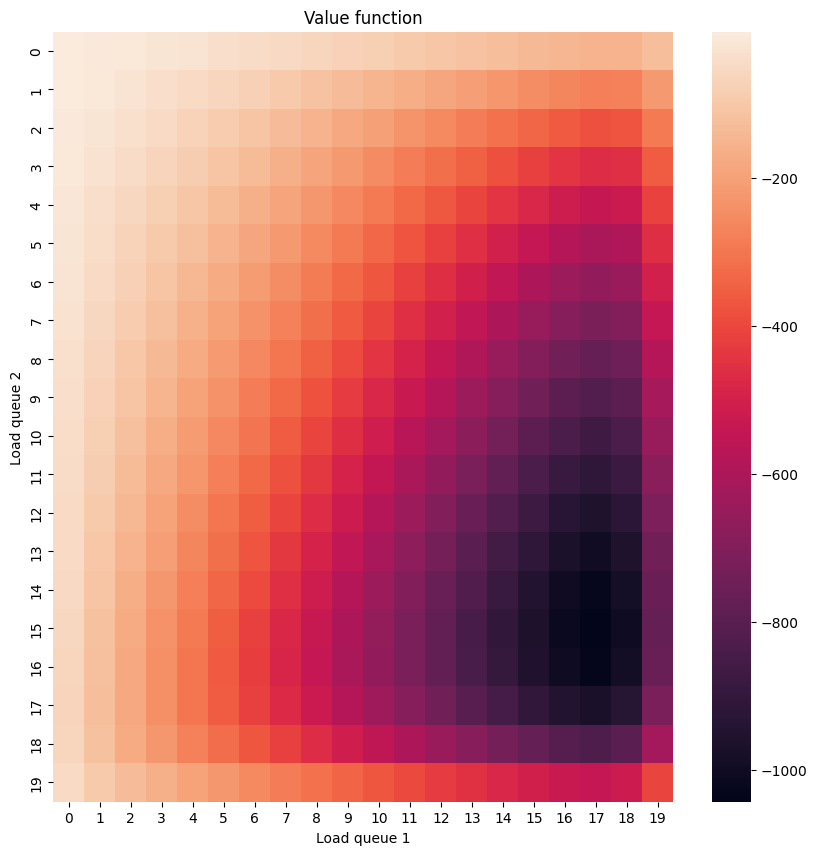

In [235]:
# Plot the value function
V = computeValueFunctionMDPRecc(lambdA, mu1, mu2, gamma, Q1_max, Q2_max, 100, 0.01)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(V, annot=False, ax=ax)
plt.xlabel("Load queue 1")
plt.ylabel("Load queue 2")
plt.title("Value function")
plt.show()

Converged in  100  iterations.


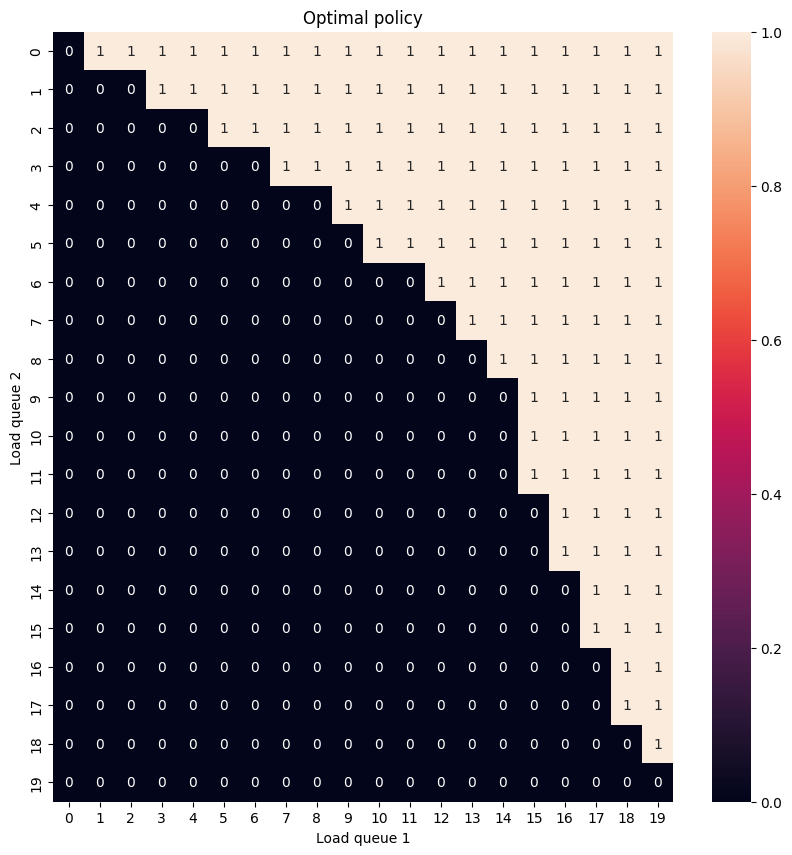

In [236]:
# Plot the optimal policy
pi, V = optimalControlMDP(lambdA, mu1, mu2, gamma, Q1_max, Q2_max, 100, 0.01)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pi, annot=True, ax=ax)
plt.xlabel("Load queue 1")
plt.ylabel("Load queue 2")
plt.title("Optimal policy")
plt.show()

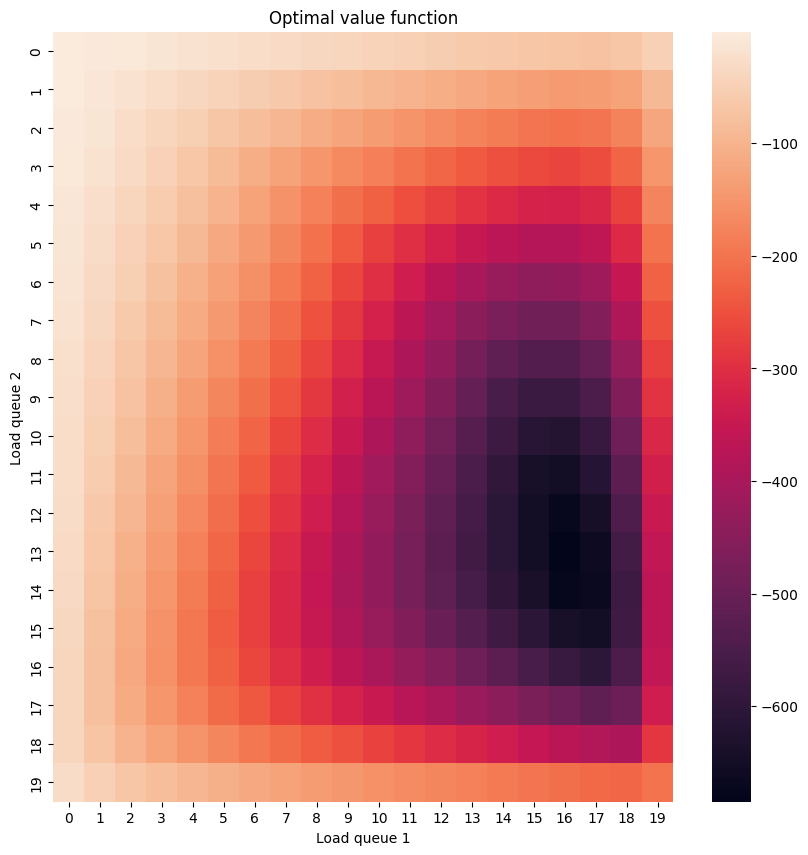

In [237]:
# Plot optimal value function
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(V, annot=False, ax=ax)
plt.xlabel("Load queue 1")
plt.ylabel("Load queue 2")
plt.title("Optimal value function")
plt.show()

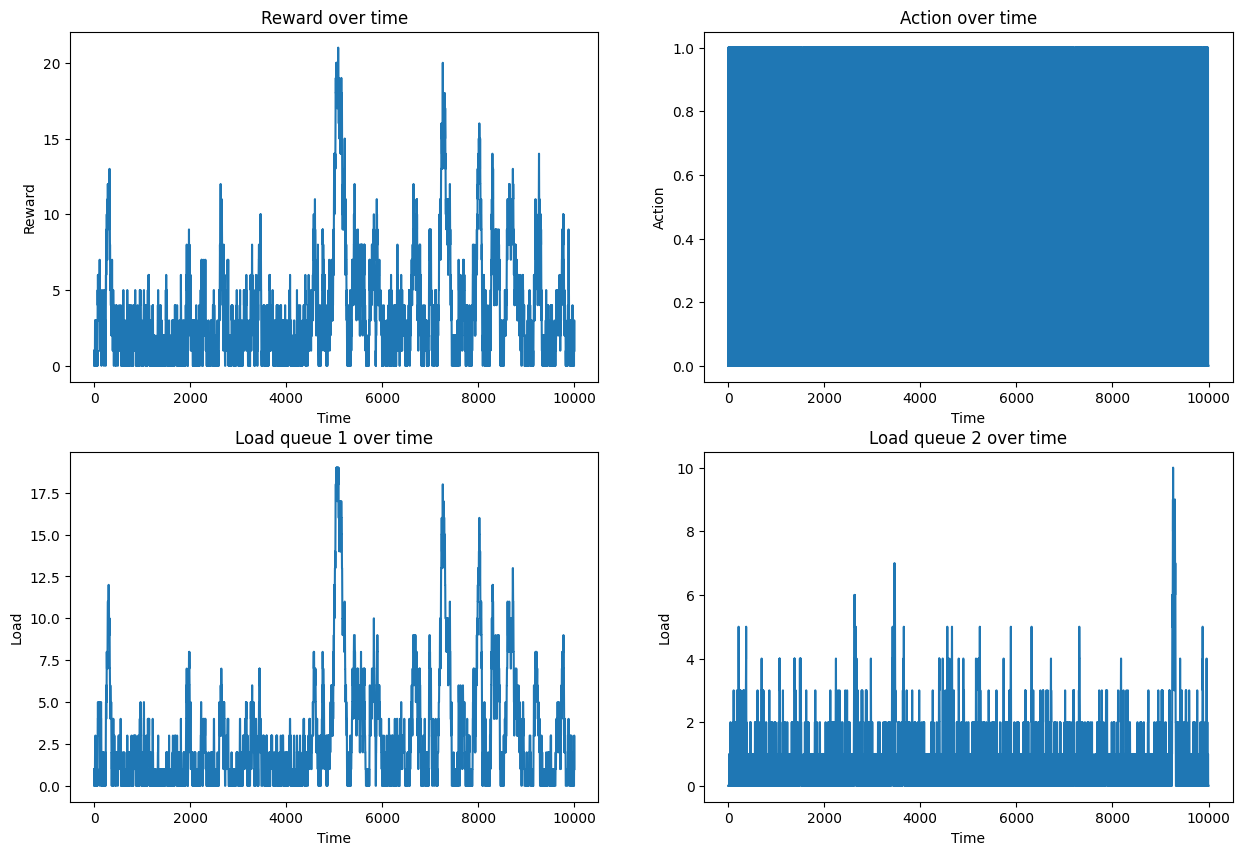

In [238]:
# Simulate
N = 10000
rewards, actions, load_1, load_2 = simulateLoadBalencing(lambdA, mu1, mu2, gamma, Q1_max, Q2_max, N)
# Plot
plotResults(rewards, actions, load_1, load_2, N)

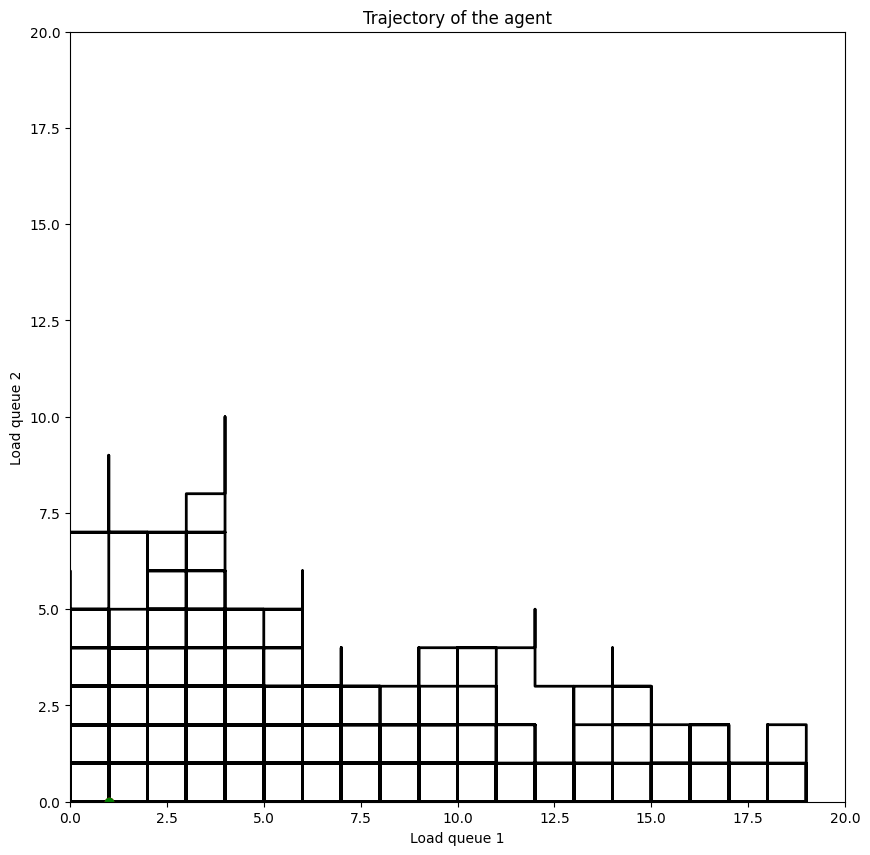

In [239]:
# Plot trajectory
plotTrajectory(load_1, load_2, N, Q1_max, Q2_max)